Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

## Data preparation

installing dependencies for pycaret library:

In [1]:
!wget https://raw.githubusercontent.com/pycaret/pycaret/master/requirements.txt

!pip install -r requirements.txt -U

!pip install -U pycaret

--2021-11-15 02:50:56--  https://raw.githubusercontent.com/pycaret/pycaret/master/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 383 [text/plain]
Saving to: ‘requirements.txt.9’

requirements.txt.9  100%[===================>]     383  --.-KB/s    in 0s      

2021-11-15 02:50:57 (7.74 MB/s) - ‘requirements.txt.9’ saved [383/383]

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: pandas in /home/jovyan/.local/lib/python3.7/site-packages (from -r requirements.txt (line 1)) (1.3.4)
Requirement already up-to-date: scipy<=1.5.4 in /home/jovyan/.local/lib/python3.7/site-packages (from -r requirements.txt (line 2)) (1.5.4)
Requirement already up-to-date: numpy==1.19.5 in /opt/conda/lib/py

Import libraries:

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pycaret.regression as pycr
from pycaret.regression import *
import pycaret.utils as pycu
#ignoring warning
import warnings
import hashlib
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


make a try-except block in order to avoid file path error when working both locally and remotely.

In [3]:
try:
    df = pd.read_csv('car_data.csv')
    
except:   
    df = pd.read_csv('/datasets/car_data.csv')

### Explorantory Data Analysis:

Checking the data's first 5 observations:

In [4]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


Checking the df's info:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

We will remove the following columns: DateCrawled, NumberOfPictures, DateCreated, PostalCode and LastSeen, as they dont provide useful information regarding price prediction and could confuse and misslead our models.

In [6]:
df = df.drop(['DateCrawled','NumberOfPictures','DateCreated','PostalCode','LastSeen','RegistrationMonth'], axis=1)

Lower casing our columns:

In [7]:
df.columns= df.columns.str.lower()

Checking for duplicates:

In [8]:
df.duplicated().sum()

45040

We see we have many duplicated rows, we will run our models both with them and without them

Checking for missing values:

In [9]:
df.isna().sum()

price                   0
vehicletype         37490
registrationyear        0
gearbox             19833
power                   0
model               19705
mileage                 0
fueltype            32895
brand                   0
notrepaired         71154
dtype: int64

In [10]:
abs_value_t = df.isna().any(axis=1).sum()
pct_t = round(abs_value_t / len(df) * 100,2)
print('num of rows with missing values: {}, {}% of total'.format(abs_value_t, pct_t))

num of rows with missing values: 108555, 30.63% of total


We see we have many rows with missing values. We will try predicting with dropping the missing values, and with trying to impute some of them.

checking the df's descriptive statistics for the numerical columns:

In [11]:
df.describe()

,price,registrationyear,power,mileage
count,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535
std,4514.158514,90.227958,189.850405,37905.341530
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


We can already tell we have some unreasonable values, such as 20000 power (hp), registartion year of 1000 and up to 9999.

Checking for unique value for each feature:

In [12]:
dataset_ = df.select_dtypes(include='object')
for col in dataset_.columns:
    print('{}\n'.format(col) + 'unique count : ' + '{}'.format(df[col].nunique()))
    print(df[col].unique())
    print('')

vehicletype
unique count : 8
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']

gearbox
unique count : 2
['manual' 'auto' nan]

model
unique count : 250
['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 

- we will transform notreparied yes / no to 1 and 0, and gearbox manual/ auto to 0 and 1

In [13]:
df2 = df.copy()

In [14]:
df2.notrepaired = df2.notrepaired.map(dict(yes=1, no=0))
df2.gearbox = df2.gearbox.map(dict(auto=1, manual=0))

In [15]:
df2.head()

,price,vehicletype,registrationyear,gearbox,power,model,mileage,fueltype,brand,notrepaired
0,480,NaN,1993,0.0,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,0.0,190,NaN,125000,gasoline,audi,1.0
2,9800,suv,2004,1.0,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,0.0,75,golf,150000,petrol,volkswagen,0.0
4,3600,small,2008,0.0,69,fabia,90000,gasoline,skoda,0.0


checking for outliers:

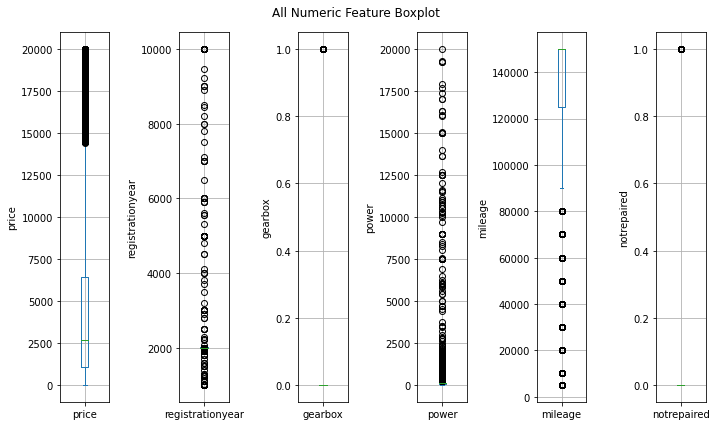

In [16]:
selection = df2.select_dtypes(exclude=object)
fig, ax = plt.subplots(1, len(selection.columns), figsize=(10, len(selection.columns)))

for i, col in enumerate(selection.columns):
    axo = df2[col].plot(kind='box', ax=ax[i], showfliers=True, grid=True)
    axo.set_ylabel(col)

plt.suptitle('All Numeric Feature Boxplot')    
plt.tight_layout()
plt.show()

#### Description:
- This plot shows box-plots for every numeric feature.
- There are outliers in some features. We will use precentiles to determine the valid range of values for registrationyear and for power. The dependant variable, "price", is left out to maintain the data originality.

checking the percentiles for reasonable values:

In [17]:
lower_pct_year = np.percentile(df2.registrationyear, 0.5, axis =0)
upper_pct_year = np.percentile(df2.registrationyear, 99, axis =0)

print('0.5%: {} '.format(lower_pct_year))
print('99%: {} '.format(upper_pct_year))

0.5%: 1971.0 
99%: 2018.0 


In [18]:
lower_pct_power = np.percentile(df2.power, 12, axis =0)
upper_pct_power = np.percentile(df2.power, 99.8, axis =0)

print('12%: {} '.format(lower_pct_power))
print('99.8%: {} '.format(upper_pct_power))

12%: 43.0 
99.8%: 420.0 


creating a new df with removed invalid values for registartion year.

In [19]:
df3 = df2.loc[(df["registrationyear"] >= lower_pct_year) & (df["registrationyear"] <= upper_pct_year)]
df3 = df2.loc[(df2["power"] >= lower_pct_power) & (df2["power"] <= upper_pct_power)]

new df with null removal:

In [20]:
df4 = df3.copy()
df4 = df4.dropna()
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 234628 entries, 3 to 354367
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   price             234628 non-null  int64  
 1   vehicletype       234628 non-null  object 
 2   registrationyear  234628 non-null  int64  
 3   gearbox           234628 non-null  float64
 4   power             234628 non-null  int64  
 5   model             234628 non-null  object 
 6   mileage           234628 non-null  int64  
 7   fueltype          234628 non-null  object 
 8   brand             234628 non-null  object 
 9   notrepaired       234628 non-null  float64
dtypes: float64(2), int64(4), object(4)
memory usage: 19.7+ MB


checking for  %amount of rows with price = 0:

In [21]:
round(len(df4.query('price == 0')) / len(df4) * 100,2)

1.23

We will remove those rows as they are 1.2% of the current data

In [22]:
df4 = df4.query('price > 0')

checking for mean prices for each brand:

In [23]:
df4.groupby('brand')['price'].mean().sort_values(ascending=False)

brand
porsche          12671.360324
land_rover        9562.222785
mini              9530.766426
jeep              7757.321429
jaguar            7455.308943
audi              7231.816371
bmw               7047.555271
mercedes_benz     6650.556942
skoda             6555.313850
dacia             6073.666667
chevrolet         6041.613770
hyundai           5801.287624
kia               5727.071023
volkswagen        5344.355950
toyota            5191.051779
volvo             5019.150274
nissan            4990.498144
seat              4817.212698
trabant           4649.500000
suzuki            4588.741793
subaru            4495.515810
honda             4417.426463
mazda             4357.811421
alfa_romeo        4337.546250
chrysler          4328.724544
smart             4210.380537
saab              4182.828784
citroen           3985.778792
ford              3920.636199
lada              3719.500000
peugeot           3668.050699
mitsubishi        3595.309062
opel              3397.199877
fiat

#### Description:
- We are picking all brands that their price is > 6500 and consider them premium brands.
- We see our premium brands regarding their average price are: porsche, land rover, mini, jeep, jaguar, audi, bmw, mercedes and skoda. 
- We are going to create a new feature named is_premium based on those brands.

creating the new feature:

In [24]:
premium_makes = ['porsche', 'land_rover', 'mini', 'jeep', 'jaguar', 'audi','bmw','mercedes_benz','skoda']
df4['ispremium'] = [1 if name in premium_makes else 0 for name in df4.brand]

In [25]:
df4.head()

,price,vehicletype,registrationyear,gearbox,power,model,mileage,fueltype,brand,notrepaired,ispremium
3,1500,small,2001,0.0,75,golf,150000,petrol,volkswagen,0.0,0
4,3600,small,2008,0.0,69,fabia,90000,gasoline,skoda,0.0,1
5,650,sedan,1995,0.0,102,3er,150000,petrol,bmw,1.0,1
6,2200,convertible,2004,0.0,109,2_reihe,150000,petrol,peugeot,0.0,0
10,2000,sedan,2004,0.0,105,3_reihe,150000,petrol,mazda,0.0,0


Plotting correlation table:

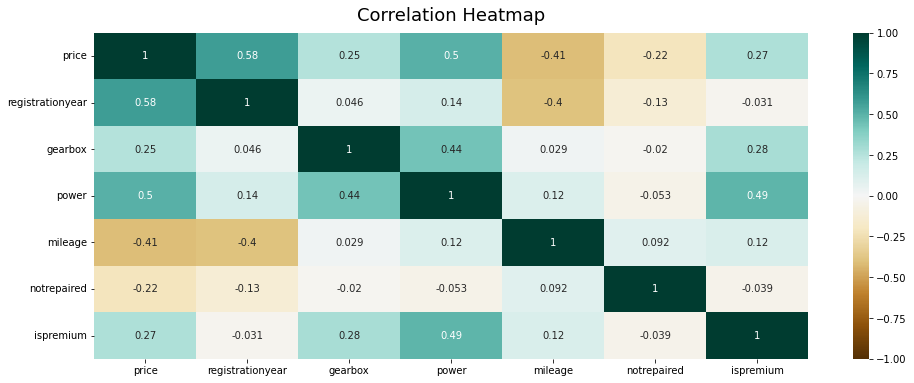

In [26]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df4.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

#### Description:
- We see price(our target variable) correlates with registartion year and power the most.
- We see there are no multicollinearity problems right now with our features.
- We will create an additional feature to indicate wether our engine is powerful or not

Our threshold to indicate wether the engine is powerful or not:

In [27]:
threshold = df4.power.min() + (df4.power.max() - df4.power.min()) / 2
threshold

231.5

In [28]:
df4['powerful_engine'] = [1 if power >= threshold else 0 for power in df4.power]

In [29]:
data = df4.copy()

#### Encoding: 
Replacing remaining object features with one-hot dummies if the certain feature has few unique values or with hash if there are many uniques

In [30]:
cols_to_drop = []
len_data = len(data)

for col in data.drop(columns=['price']).columns:
    if data[col].dtype == 'object':
        print(f'Column {col} has {data[col].nunique()} values among {len_data}')

        if data[col].nunique() < 25:
            print(f'One-hot encoding of {col}')
            one_hot_cols = pd.get_dummies(data[col], drop_first=True)
        for ohc in one_hot_cols.columns:
            data[col + '_' + ohc] = one_hot_cols[ohc]
        else:
            print(f'Hashing of {col}')
            data[col + '_hash'] = data[col].apply(lambda row: int(hashlib.sha1((col + "_" + str(row)).encode('utf-8')).hexdigest(), 16) % len_data)

        cols_to_drop.append(col)
    
data = data.drop(columns=cols_to_drop)

Column vehicletype has 8 values among 231747
One-hot encoding of vehicletype
Hashing of vehicletype
Column model has 249 values among 231747
Hashing of model
Column fueltype has 7 values among 231747
One-hot encoding of fueltype
Hashing of fueltype
Column brand has 39 values among 231747
Hashing of brand


Removing the features with high correlation to reduce the model dimensionality and avoid information redundancy

In [31]:
corr = data.drop(columns=["price"]).corr()
corr_top = corr.abs().unstack().sort_values(kind='quicksort')
corr_top = corr_top[corr_top > 0.9][corr_top < 1]

cols_to_drop = [corr_top.index[i][0] for i in range(0, len(corr_top), 2)]
print(f"Highly correlated features: {cols_to_drop}")
data = data.drop(columns=cols_to_drop)

data

Highly correlated features: ['brand_gasoline', 'fueltype_petrol', 'fueltype_petrol', 'fueltype_gasoline', 'brand_petrol', 'fueltype_hash', 'fueltype_hash', 'fueltype_hash']


,price,registrationyear,gearbox,power,mileage,notrepaired,ispremium,powerful_engine,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,vehicletype_suv,vehicletype_wagon,vehicletype_hash,model_convertible,model_coupe,model_other,model_sedan,model_small,model_suv,model_wagon,model_hash,fueltype_electric,fueltype_hybrid,fueltype_lpg,fueltype_other,brand_electric,brand_hybrid,brand_lpg,brand_other,brand_hash
3,1500,2001,0.0,75,150000,0.0,0,0,0,0,0,0,1,0,0,81662,0,0,0,0,1,0,0,35048,0,0,0,0,0,0,0,0,51833
4,3600,2008,0.0,69,90000,0.0,1,0,0,0,0,0,1,0,0,81662,0,0,0,0,1,0,0,173017,0,0,0,0,0,0,0,0,18708
5,650,1995,0.0,102,150000,1.0,1,0,0,0,0,1,0,0,0,99003,0,0,0,1,0,0,0,35430,0,0,0,0,0,0,0,0,195956
6,2200,2004,0.0,109,150000,0.0,0,0,1,0,0,0,0,0,0,130270,1,0,0,0,0,0,0,127265,0,0,0,0,0,0,0,0,86231
10,2000,2004,0.0,105,150000,0.0,0,0,0,0,0,1,0,0,0,99003,0,0,0,1,0,0,0,88570,0,0,0,0,0,0,0,0,131407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354358,1490,1998,0.0,50,150000,0.0,0,0,0,0,0,0,1,0,0,81662,0,0,0,0,1,0,0,41295,0,0,0,0,0,0,0,0,51833
354359,7900,2010,0.0,140,150000,0.0,0,0,0,0,0,1,0,0,0,99003,0,0,0,1,0,0,0,35048,0,0,0,0,0,0,0,0,51833
354362,3200,2004,0.0,225,150000,1.0,0,0,0,0,0,1,0,0,0,99003,0,0,0,1,0,0,0,219264,0,0,0,0,0,0,0,0,188346
354366,1199,2000,1.0,101,125000,0.0,0,0,1,0,0,0,0,0,0,130270,1,0,0,0,0,0,0,135068,0,0,0,0,0,0,0,0,57828


In [32]:
data = data.reset_index(drop=True)

Splitting to training and test data before scaling:

In [33]:
features = data.drop(columns=['price'])
target = data.price

X_train, X_test, y_train, y_test = train_test_split(features,target, random_state=42,train_size=0.8)

In [34]:
# Rescaling the feaures
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Conclusion:


- We have removed features, created new features, got rid of illogical values,encoded the categorical features and scaled the features.

## Model training

number of rows for train set for pycaret:

In [35]:
rows = round(len(data) * 0.8)

In [36]:
dftrain = data.sample(n= rows, random_state=42)
dftest = data.drop(dftrain.index)

dftrain.reset_index(drop=True, inplace=True)
dftest.reset_index(drop=True, inplace=True)

## ** Please press enter in the bar at the boottom of the next cell when it asks for it. **

In [37]:
pycaret_exp = pycr.setup(data=dftrain, target="price", session_id=42)

,Description,Value
0,session_id,42
1,Target,price
2,Original Data,"(185398, 33)"
3,Missing Values,False
4,Numeric Features,26
5,Categorical Features,6
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(129778, 30)"


training and evaluating over 15 models using cross validation. sorting by RMSE 

In [38]:
%%time
best = pycr.compare_models(sort='RMSE', fold = 5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,1038.3088,2707172.8266,1645.1690,0.8784,0.4873,3.9225,44.5480
et,Extra Trees Regressor,1063.7331,2882922.2251,1697.7850,0.8705,0.5049,3.8648,40.0040
lightgbm,Light Gradient Boosting Machine,1118.7627,2909087.1868,1705.4966,0.8693,0.5041,4.0912,3.9900
knn,K Neighbors Regressor,1168.1668,3440119.4740,1854.6954,0.8455,0.5217,4.3717,7.0660
gbr,Gradient Boosting Regressor,1270.9514,3644604.1337,1908.9448,0.8363,0.5688,4.2760,11.8300
dt,Decision Tree Regressor,1169.3598,3765450.6709,1940.1167,0.8308,0.5669,3.7787,0.6800
br,Bayesian Ridge,2036.2102,7900248.8143,2810.6327,0.6451,0.8385,5.5369,1.0300
ridge,Ridge Regression,2036.2187,7900361.4723,2810.6529,0.6451,0.8388,5.5376,0.3160
lar,Least Angle Regression,2036.2231,7900427.2747,2810.6646,0.6451,0.8388,5.5378,0.3740
lasso,Lasso Regression,2036.5170,7902574.7645,2811.0433,0.6450,0.8384,5.5314,14.3160


CPU times: user 12min 51s, sys: 1min 37s, total: 14min 28s
Wall time: 14min 34s


manually checking for CatBoost since its not included in the standard installtion of pycaret and the full version doesnt work on the hub for some reason.

In [39]:
cbr = CatBoostRegressor(random_state=42, verbose=0)

In [40]:
cbr.fit(X_train, y_train)
cb_mse = round(mean_squared_error(y_test, cbr.predict(X_test)), 2)
cb_rmse = np.sqrt(cb_mse)

In [41]:
print("CatBoost RMSE on CV is {}".format(round(cb_rmse, 2)))

CatBoost RMSE on CV is 1667.95


We choose to advance and try tuning Random Forest regressor and lightGBM

### RF:

In [42]:
%%time
rf = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1022.9325,2656168.4740,1629.7756,0.8780,0.4866,3.9395
1,1032.5822,2651690.2061,1628.4011,0.8818,0.4796,2.8128
2,1018.2044,2600395.7128,1612.5743,0.8839,0.4934,4.5214
3,1018.0894,2588091.8278,1608.7547,0.8848,0.4837,2.4043
4,1006.7674,2467618.0857,1570.8654,0.8882,0.5038,4.4676
5,1028.6350,2688805.9893,1639.7579,0.8793,0.4771,5.0383
6,1051.7786,2817895.0947,1678.6587,0.8753,0.5007,6.9788
7,1034.1577,2775551.4833,1665.9986,0.8728,0.4523,1.7907
8,1039.3931,2742389.9694,1656.0163,0.8786,0.4989,3.7790
9,1034.8099,2648701.7071,1627.4832,0.8805,0.4719,3.2296


CPU times: user 9min 22s, sys: 4.02 s, total: 9min 26s
Wall time: 9min 31s


Evaluate this model on the hold_out sample

In [43]:
predict_result = pycr.predict_model(rf)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,1016.1226,2664379.7447,1632.2928,0.8801,0.4705,3.5128


### LGBM:

In [44]:
%%time
lightgbm = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1113.3687,2894208.1321,1701.2372,0.8671,0.5057,4.1418
1,1125.6692,2926519.4658,1710.7073,0.8696,0.4993,3.0479
2,1112.5414,2946978.8958,1716.6767,0.8685,0.5108,4.6024
3,1111.2337,2865486.0318,1692.7747,0.8724,0.5029,2.6990
4,1083.2382,2631893.8236,1622.3113,0.8807,0.5180,4.7977
5,1117.8670,2909502.0790,1705.7263,0.8693,0.4984,4.7024
6,1138.0810,3029515.6657,1740.5504,0.8659,0.5195,6.8804
7,1118.0752,2956014.0704,1719.3063,0.8645,0.4726,1.9033
8,1119.0920,2924740.9984,1710.1874,0.8706,0.5141,4.5181
9,1128.7459,2922577.7264,1709.5548,0.8682,0.4914,3.2620


CPU times: user 49.4 s, sys: 364 ms, total: 49.8 s
Wall time: 50.7 s


Evaluate this model on the hold_out sample

In [45]:
predict_result = pycr.predict_model(lightgbm)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1118.6640,2951942.3432,1718.1217,0.8671,0.4927,3.7590


### tuning:

#### RF Tune:

In [46]:
grid_rf = {'n_estimators': [3, 5, 10, 50, 100],
                     'min_samples_split': [5, 8, 10, 12],
                     'max_depth' : [2, 4, 6, 8, 10]
                    }

In [47]:
%%time
tuned_rf = pycr.tune_model(rf, fold = 5, custom_grid = grid_rf, optimize='RMSE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1242.5250,3486640.8190,1867.2549,0.8423,0.5493,3.7659
1,1250.2579,3523474.3339,1877.0920,0.8429,0.5590,3.7719
2,1233.4050,3398754.6145,1843.5712,0.8467,0.5564,5.0564
3,1255.1729,3636657.3146,1907.0022,0.8363,0.5458,4.5907
4,1258.0420,3644290.0241,1909.0024,0.8372,0.5520,4.2797
Mean,1247.8805,3537963.4212,1880.7845,0.8411,0.5525,4.2929
SD,8.9477,93025.6589,24.7594,0.0039,0.0047,0.4942


CPU times: user 3min 18s, sys: 0 ns, total: 3min 18s
Wall time: 3min 20s


We see our tuned rf performed worse than using default settings, we will test both on the test set later on.

predicting the hold-out sample using the tuned RF:

In [48]:
predict_model(tuned_rf);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,1243.4433,3547581.6123,1883.5025,0.8403,0.5412,3.9161


#### LGBM Tune:

In [49]:
lgbm_params = {'num_leaves': np.arange(10,200,10),
                        'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
                        'learning_rate': np.arange(0.1,1,0.1)
                        }

In [50]:
%%time
tuned_lgbm = pycr.tune_model(lightgbm, fold = 5, custom_grid = lgbm_params, optimize='RMSE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1029.7960,2631158.5787,1622.0846,0.8810,0.4951,3.5387
1,1020.8102,2598721.4409,1612.0550,0.8842,0.5039,3.4188
2,1020.4281,2548692.8672,1596.4626,0.8850,0.4999,4.6383
3,1031.5049,2643556.3348,1625.9017,0.8810,0.4875,4.2349
4,1034.2072,2638022.3663,1624.1990,0.8821,0.5001,3.8012
Mean,1027.3493,2612030.3176,1616.1406,0.8827,0.4973,3.9264
SD,5.6736,35282.0792,10.9496,0.0017,0.0057,0.4529


CPU times: user 6min 31s, sys: 3.68 s, total: 6min 35s
Wall time: 6min 40s


We see our tuned lgbm is performing better! RMSE of 1616 instead of 1702.

Printing the tuned parameters:

In [51]:
print(tuned_lgbm)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.5, max_depth=110,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=190, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


predicting the hold-out sample using the tuned lgbm:

In [52]:
predict_model(tuned_lgbm);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1011.3844,2581087.0280,1606.5762,0.8838,0.4797,3.6795


##### Finalzing the model:

- The finalize_model() function fits the model onto the complete dataset including the test/hold-out sample (20% in this case). The purpose of this function is to train the model on the complete dataset before it is deployed in production (in our case to use it on the unseen data(dftest))

In [53]:
%%time
final_lightgbm = finalize_model(tuned_lgbm)

CPU times: user 2min 5s, sys: 1.55 s, total: 2min 7s
Wall time: 2min 9s


##### Predict on unseen data:

In [54]:
unseen_predictions = predict_model(final_lightgbm, data=dftest)

checking the RMSE value on the test set:

In [56]:
pycu.check_metric(unseen_predictions.price, unseen_predictions.Label, 'RMSE')

1590.4699

Our final RMSE is 1590, which is a slight improvment from our train set - meaning we are not experiencing overfitting.

## Model analysis

### Quality of models:

We chose the best performing ensamble model: RF Regressor, and the best gradient boosting model between the models we tested: LightGBM.

- RF Regressor reached RMSE of 1880.
- LGBM reached RMSE of 1590 on the test set, and is the best performing model.
- We also achivied MAPE score of 3.8%, which implies that, on average, the forecast's distance from the true value is 3.8% of the true value.

### Speed of models analysis:
We recorded the speed of models using the time decorator (%%time) in the cells where our models got fitted and tuned.

- the inital models comparison took us 14min and 30s
- training and evaluation of the performance of RF regressor using cross validation took us 9min 18s
- training and evaluation of the performance of LGBM regresor using cross validation took us 47s.
- Tuning of RF regressor took us 3min 17s
- Tuning of LGBM regressor took us 6min 21s


- LGBM total (training + tuning): 7m 8s
- RF Regressor total(Training + tuning): 12m 35s

We can conclude LGBM is faster and achieved better results.